# **Slide-seq lung metabolic Hotspot robustness analysis**

This notebook reproduces the figures present in Fig S3.

In [1]:
import harreman
import os
import json
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from scipy.stats import pearsonr, wilcoxon, mannwhitneyu, ranksums, spearmanr
import random
import scipy.stats as stats
from sklearn import linear_model
from scipy.stats import hypergeom, zscore, norm
from statsmodels.stats.multitest import multipletests
from plotnine import *
from matplotlib.patches import Patch
from scipy.cluster.hierarchy import fcluster
from numba import jit, njit
import warnings
warnings.filterwarnings("ignore")


BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Slide_seq_lung"
ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

## Load dataset

Load the AnnData file and create the Hotspot object.

In [2]:
adata = sc.read_h5ad(os.path.join(ADATA_PATH, 'Slide_seq_lung_adata.h5ad'))

Filter out genes expressed in less than 50 spots per sample

In [3]:
sample_col = 'sample'
n_genes_expr = 50
genes_to_keep = np.zeros(adata.shape[1], dtype=bool)

for sample in adata.obs[sample_col].unique():
    adata_sample = adata[adata.obs[sample_col] == sample]
    expressed = np.array((adata_sample.X > 0).sum(axis=0)).flatten()
    genes_to_keep |= expressed >= n_genes_expr

adata = adata[:, genes_to_keep]

## Autocorrelation

In [4]:
neighborhood_radius_values = [50, 100, 150, 200, 250, 300, 350, 400]
ref_value = 100

In [5]:
def autocorrelation_robustness_pipeline(adata, neighborhood_radius):
    
    harreman.tl.compute_knn_graph(adata,
                           compute_neighbors_on_key="spatial",
                           neighborhood_radius=neighborhood_radius,
                           weighted_graph=False,
                           sample_key='sample')
    
    n_neighbors = adata.obsp['weights'].sum(axis=1).A1
    
    harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='bernoulli', species='human', use_metabolic_genes=True)
    
    gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
    
    return gene_autocorrelation_results, n_neighbors

In [6]:
gene_autocorrelation_results_dict = {}
n_neighbors_dict = {}
for neighborhood_radius in neighborhood_radius_values:
    print(neighborhood_radius)
    gene_autocorrelation_results, n_neighbors = autocorrelation_robustness_pipeline(adata, neighborhood_radius)
    gene_autocorrelation_results_dict[neighborhood_radius] = gene_autocorrelation_results
    n_neighbors_dict[neighborhood_radius] = n_neighbors

50


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


100


100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


150


100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


200


100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.47 GiB. GPU 

In [ ]:
for key, df in gene_autocorrelation_results_dict.items():
    df["Rank"] = range(1, len(df)+1)

In [ ]:
C_df = pd.concat(
    {key: df["C"] for key, df in gene_autocorrelation_results_dict.items()}, axis=1
)

C_diff_df = C_df.subtract(C_df.loc[:, ref_value], axis=0)

C_rank_df = pd.concat(
    {key: df["Rank"] for key, df in gene_autocorrelation_results_dict.items()}, axis=1
)

In [ ]:
C_diff_melt = C_diff_df.reset_index().melt(
    id_vars="Gene", 
    var_name="Radius", 
    value_name="Value"
)

C_rank_melt = C_rank_df.reset_index().melt(
    id_vars="Gene", 
    var_name="Radius", 
    value_name="Value"
)

In [ ]:
C_diff_melt['Rank'] = C_rank_melt['Value']

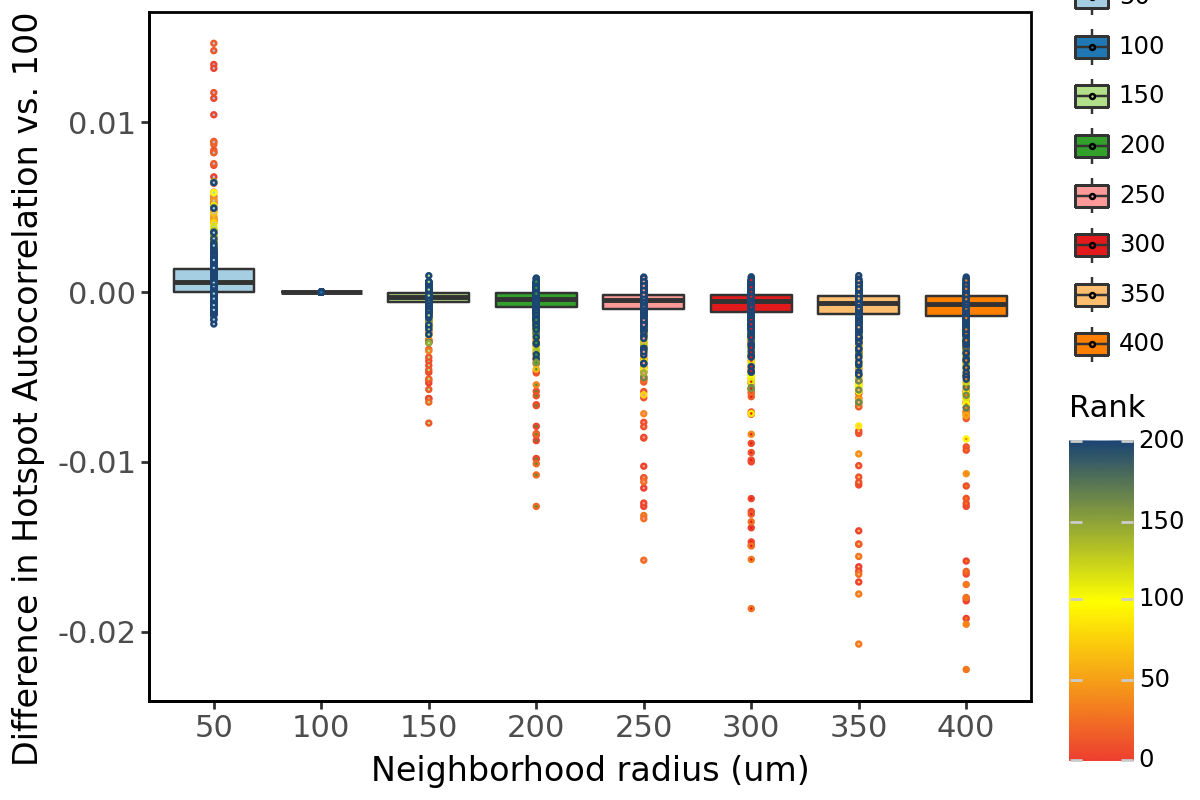

In [ ]:
fig = (
ggplot(data=C_diff_melt, mapping=aes(x="Radius", y="Value", fill="Radius"))
# + geom_boxplot(width=0.8, size=0.3, outlier_size=0.5, varwidth=True)
+ geom_boxplot(outlier_shape="")
+ geom_point(aes(color="Rank"), size=0.5, data=C_diff_melt, show_legend=True)
+ scale_fill_manual(values=["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00"])
+ scale_color_gradientn(
        colors=["#ED3E30", "yellow", "#1C4573"],  # Define multiple colors
        limits=(0, 200))
+ xlab('Neighborhood radius (um)')
+ ylab('Difference in Hotspot Autocorrelation vs. 100 um')
# + ylim(-0.1, 0.1)
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
fig.save(os.path.join(PLOTS_PATH, 'autocor_robustness_box_plot.svg'), format='svg')
# fig.save(os.path.join(PLOTS_PATH, 'autocor_robustness_box_plot_leg.svg'), format='svg')
fig

In [ ]:
n_neighbors_df = pd.DataFrame(
    [(key, value) for key, array in n_neighbors_dict.items() for value in array],
    columns=["Radius", "Value"]
)
n_neighbors_df["Radius"] = n_neighbors_df["Radius"].astype('category')

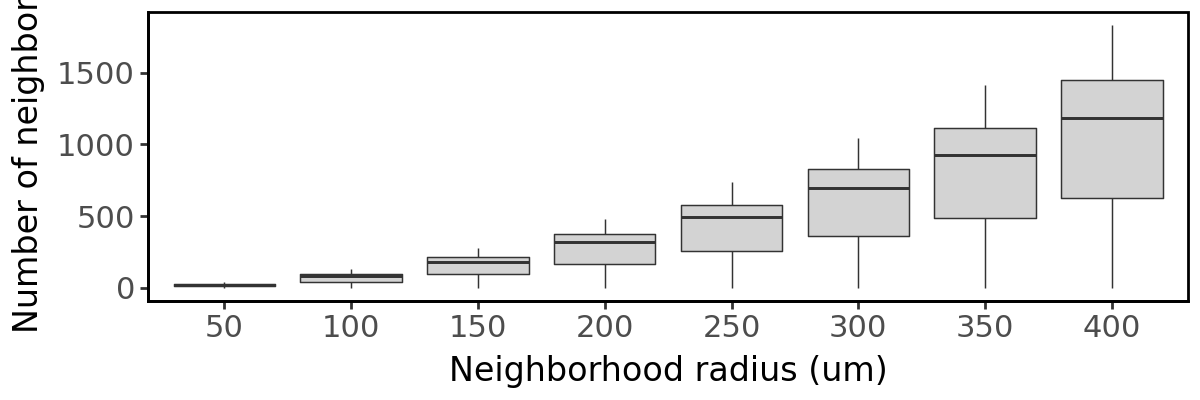

In [ ]:
fig = (
ggplot(data=n_neighbors_df, mapping=aes(x="Radius", y="Value", fill="Radius")) 
# + geom_point(alpha=0.2, color='gray', fill='gray')
+ geom_boxplot(width=0.8, size=0.3, outlier_size=0.2, varwidth=True, fill='lightgrey')
+ xlab('Neighborhood radius (um)')
+ ylab('Number of neighbors')
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 2))
)
# fig.save(os.path.join(PLOTS_PATH, 'autocor_n_neighbors_box_plot.svg'), format='svg')
fig

## Pairwise correlation (neighborhood radius)

In [ ]:
neighborhood_radius_values = [50, 100, 150, 200, 250, 300, 350, 400]
ref_value = 100

In [ ]:
def pairwise_correlation_robustness_pipeline(adata, neighborhood_radius):
    
    harreman.tl.compute_knn_graph(adata,
                           compute_neighbors_on_key="spatial",
                           neighborhood_radius=neighborhood_radius,
                           weighted_graph=False,
                           sample_key='sample')
        
    harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='bernoulli', species='human', use_metabolic_genes=True)
    
    gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
    genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index
    
    harreman.hs.compute_local_correlation(adata, genes=genes)
    
    harreman.hs.create_modules(adata, min_gene_threshold=20)
    
    harreman.hs.calculate_module_scores(adata)
    
    return adata.uns['gene_modules'], adata.obsm['module_scores']

In [ ]:
def pair_modules_by_similarity(gene_modules, module_scores, gene_modules_ref, module_scores_ref):
    
    jaccard_sim_matrix = np.zeros((len(gene_modules.keys()), len(gene_modules_ref.keys())))
    for i in range(len(gene_modules.keys())):
        for j in range(len(gene_modules_ref.keys())):
            key_i = list(gene_modules.keys())[i]
            key_j = list(gene_modules_ref.keys())[j]
            a = gene_modules[key_i]
            b = gene_modules_ref[key_j]
            jaccard_sim_matrix[i,j] = len(list(set(a) & set(b))) / len(list(set(a) | set(b)))
    jaccard_sim_matrix_df = pd.DataFrame(jaccard_sim_matrix, index=gene_modules.keys(), columns=gene_modules_ref.keys())
    
    correlation_matrix = pd.DataFrame(
        [[module_scores[col1].corr(module_scores_ref[col2]) for col2 in module_scores_ref.columns] for col1 in module_scores.columns],
        index=module_scores.columns,
        columns=module_scores_ref.columns
    )
    
    similarity_matrix = (jaccard_sim_matrix_df + correlation_matrix)/2
    max_similarity = similarity_matrix.idxmax()
    
    correlation_values = [correlation_matrix.loc[max_similarity[mod], mod] for mod in max_similarity.index]
    jaccard_values = [jaccard_sim_matrix_df.loc[max_similarity[mod], mod] for mod in max_similarity.index]
    
    return correlation_values, jaccard_values

In [24]:
pairwise_correlation_gene_modules_dict = {}
pairwise_correlation_module_scores_dict = {}
for neighborhood_radius in neighborhood_radius_values:
    print(neighborhood_radius)
    gene_modules, module_scores = pairwise_correlation_robustness_pipeline(adata, neighborhood_radius)
    pairwise_correlation_gene_modules_dict[neighborhood_radius] = gene_modules
    pairwise_correlation_module_scores_dict[neighborhood_radius] = module_scores

50


100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Creating modules...
Finished creating modules in 0.023 seconds


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


100


100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Creating modules...
Finished creating modules in 0.032 seconds


100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


150


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Creating modules...
Finished creating modules in 0.041 seconds


100%|██████████| 4/4 [00:16<00:00,  4.12s/it]


200


100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


Creating modules...
Finished creating modules in 0.050 seconds


100%|██████████| 6/6 [00:42<00:00,  7.10s/it]


250


100%|██████████| 7/7 [00:22<00:00,  3.28s/it]


Creating modules...
Finished creating modules in 0.053 seconds


100%|██████████| 6/6 [01:11<00:00, 11.85s/it]


300


100%|██████████| 7/7 [00:34<00:00,  4.95s/it]


Creating modules...
Finished creating modules in 0.060 seconds


100%|██████████| 5/5 [01:30<00:00, 18.05s/it]


350


100%|██████████| 7/7 [00:50<00:00,  7.18s/it]


Creating modules...
Finished creating modules in 0.064 seconds


100%|██████████| 6/6 [02:31<00:00, 25.21s/it]


400


100%|██████████| 7/7 [01:09<00:00,  9.96s/it]


Creating modules...
Finished creating modules in 0.068 seconds


  0%|          | 0/5 [00:32<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.20 GiB. GPU 

In [ ]:
correlation_values_dict = {}
jaccard_values_dict = {}
n_modules_dict = {}
for neighborhood_radius in neighborhood_radius_values:
    gene_modules = pairwise_correlation_gene_modules_dict[neighborhood_radius]
    module_scores = pairwise_correlation_module_scores_dict[neighborhood_radius]
    gene_modules_ref = pairwise_correlation_gene_modules_dict[ref_value]
    module_scores_ref = pairwise_correlation_module_scores_dict[ref_value]
    correlation_values, jaccard_values = pair_modules_by_similarity(gene_modules, module_scores, gene_modules_ref, module_scores_ref)
    correlation_values_dict[neighborhood_radius] = correlation_values
    jaccard_values_dict[neighborhood_radius] = jaccard_values
    n_modules_dict[neighborhood_radius] = len(gene_modules.keys())

In [ ]:
n_modules_df = pd.DataFrame.from_dict(n_modules_dict.items()).rename(columns={0: 'Radius', 1: 'n_modules'})

In [ ]:
jaccard_values_df = pd.concat(
    {key: pd.Series(list) for key, list in jaccard_values_dict.items()}, axis=1
).melt( 
    var_name="Radius", 
    value_name="Value"
)

correlation_values_df = pd.concat(
    {key: pd.Series(list) for key, list in correlation_values_dict.items()}, axis=1
).melt( 
    var_name="Radius", 
    value_name="Value"
)

In [ ]:
jaccard_values_df["Radius"] = jaccard_values_df["Radius"].astype('category')
correlation_values_df["Radius"] = correlation_values_df["Radius"].astype('category')
n_modules_df["Radius"] = n_modules_df["Radius"].astype('category')

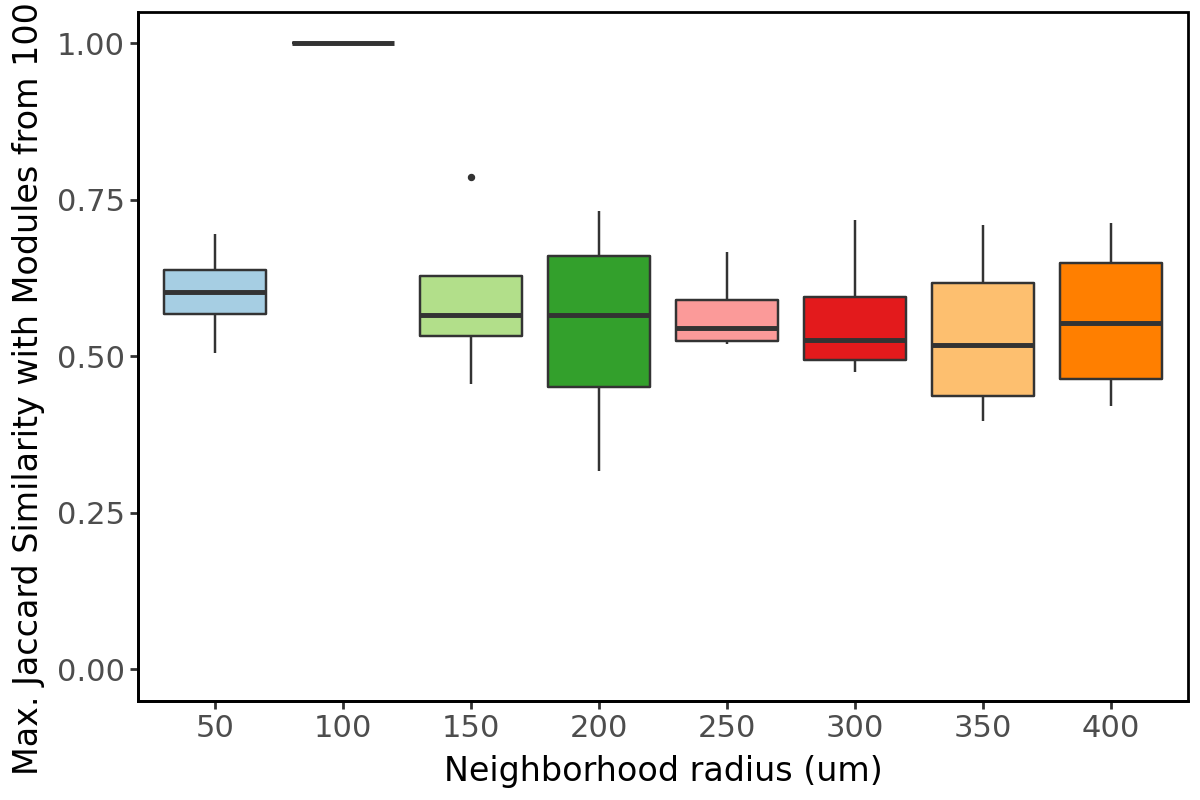

In [ ]:
fig = (
ggplot(data=jaccard_values_df, mapping=aes(x="Radius", y="Value", fill="Radius")) 
# + geom_point(alpha=0.2, color='gray', fill='gray')
+ geom_boxplot(width=0.8, outlier_shape="o", outlier_size=0.5)
# + geom_jitter(width = 0.2, size=0.5, alpha=0.6)
# + geom_boxplot(outlier_shape=None)
# + geom_point(size=0.5, alpha=0.6)
+ scale_fill_manual(values=["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6"])
+ xlab('Neighborhood radius (um)')
+ ylab('Max. Jaccard Similarity with Modules from 100 um')
+ theme_classic() 
+ ylim(0,1)
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
fig.save(os.path.join(PLOTS_PATH, 'pairwise_cor_jaccard_radius_box_plot_no_points.svg'), format='svg')
fig

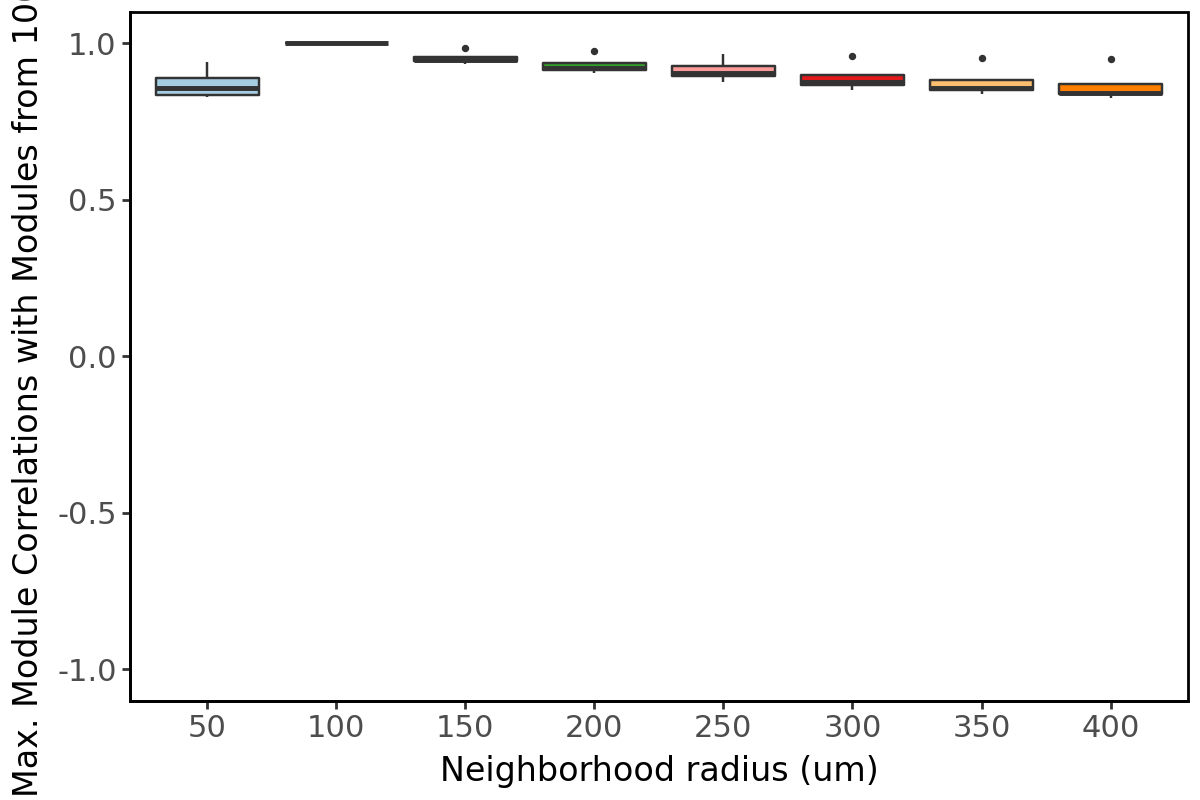

In [ ]:
fig = (
ggplot(data=correlation_values_df, mapping=aes(x="Radius", y="Value", fill="Radius")) 
# + geom_point(alpha=0.2, color='gray', fill='gray')
+ geom_boxplot(width=0.8, outlier_shape="o", outlier_size=0.5)
# + geom_jitter(width = 0.2, size=0.5, alpha=0.6)
+ scale_fill_manual(values=["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6"])
+ xlab('Neighborhood radius (um)')
+ ylab('Max. Module Correlations with Modules from 100 um')
+ theme_classic() 
+ ylim(-1,1)
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
fig.save(os.path.join(PLOTS_PATH, 'pairwise_cor_max_cor_radius_box_plot_no_points.svg'), format='svg')
fig

In [32]:
y_ticks = range(0, n_modules_df['n_modules'].max() + 2, 2)

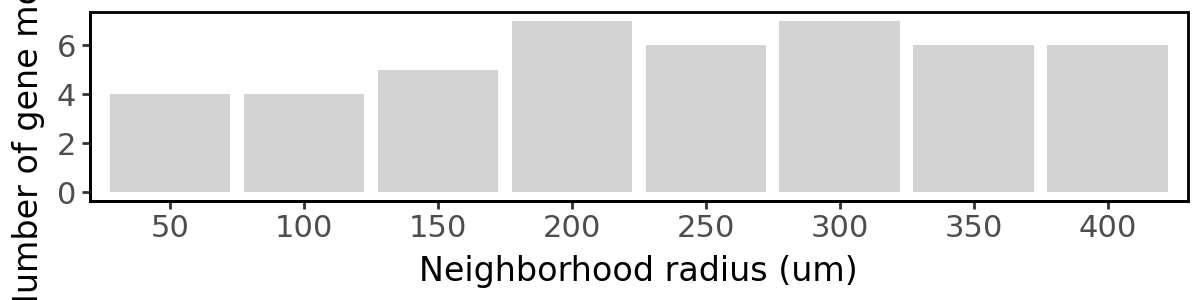

In [33]:
fig = (
ggplot(data=n_modules_df, mapping=aes(x="Radius", y="n_modules")) 
+ geom_bar(stat='identity', fill='lightgrey') 
+ xlab('Neighborhood radius (um)')
+ ylab('Number of gene modules')
+ scale_y_continuous(breaks=y_ticks)
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 1.5))
)
fig.save(os.path.join(PLOTS_PATH, 'n_modules_n_neighbors_bar_plot.svg'), format='svg')
fig

## Pairwise correlation (min_gene_threshold)

In [7]:
min_gene_threshold_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]
ref_value = 20

In [8]:
def pairwise_correlation_robustness_pipeline(adata, min_gene_threshold):
    
    harreman.tl.compute_knn_graph(adata,
                           compute_neighbors_on_key="spatial",
                           neighborhood_radius=100,
                           weighted_graph=False,
                           sample_key='sample')
        
    harreman.hs.compute_local_autocorrelation(adata, layer_key="counts", model='bernoulli', species='human', use_metabolic_genes=True)
    
    gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
    genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index
    
    harreman.hs.compute_local_correlation(adata, genes=genes)
    
    harreman.hs.create_modules(adata, min_gene_threshold=min_gene_threshold)
    
    harreman.hs.calculate_module_scores(adata)
    
    return adata.uns['gene_modules'], adata.obsm['module_scores']

In [9]:
def pair_modules_by_similarity(gene_modules, module_scores, gene_modules_ref, module_scores_ref):
    
    jaccard_sim_matrix = np.zeros((len(gene_modules.keys()), len(gene_modules_ref.keys())))
    for i in range(len(gene_modules.keys())):
        for j in range(len(gene_modules_ref.keys())):
            key_i = list(gene_modules.keys())[i]
            key_j = list(gene_modules_ref.keys())[j]
            a = gene_modules[key_i]
            b = gene_modules_ref[key_j]
            jaccard_sim_matrix[i,j] = len(list(set(a) & set(b))) / len(list(set(a) | set(b)))
    jaccard_sim_matrix_df = pd.DataFrame(jaccard_sim_matrix, index=gene_modules.keys(), columns=gene_modules_ref.keys())
    
    correlation_matrix = pd.DataFrame(
        [[module_scores[col1].corr(module_scores_ref[col2]) for col2 in module_scores_ref.columns] for col1 in module_scores.columns],
        index=module_scores.columns,
        columns=module_scores_ref.columns
    )
    
    similarity_matrix = (jaccard_sim_matrix_df + correlation_matrix)/2
    max_similarity = similarity_matrix.idxmax()
    
    correlation_values = [correlation_matrix.loc[max_similarity[mod], mod] for mod in max_similarity.index]
    jaccard_values = [jaccard_sim_matrix_df.loc[max_similarity[mod], mod] for mod in max_similarity.index]
    
    return correlation_values, jaccard_values

In [11]:
pairwise_correlation_gene_modules_dict = {}
pairwise_correlation_module_scores_dict = {}
for min_gene_threshold in min_gene_threshold_values:
    print(min_gene_threshold)
    gene_modules, module_scores = pairwise_correlation_robustness_pipeline(adata, min_gene_threshold)
    pairwise_correlation_gene_modules_dict[min_gene_threshold] = gene_modules
    pairwise_correlation_module_scores_dict[min_gene_threshold] = module_scores

10


100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Creating modules...
Finished creating modules in 0.032 seconds


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


15


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Creating modules...
Finished creating modules in 0.044 seconds


100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


20


100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Creating modules...
Finished creating modules in 0.041 seconds


100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


25


100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Creating modules...
Finished creating modules in 0.037 seconds


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


30


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Creating modules...
Finished creating modules in 0.033 seconds


100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


35


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Creating modules...
Finished creating modules in 0.033 seconds


100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


40


100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Creating modules...
Finished creating modules in 0.039 seconds


100%|██████████| 3/3 [00:07<00:00,  2.58s/it]


45


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Creating modules...
Finished creating modules in 0.033 seconds


100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


50


100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Creating modules...
Finished creating modules in 0.032 seconds


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


In [12]:
correlation_values_dict = {}
jaccard_values_dict = {}
n_modules_dict = {}
for min_gene_threshold in min_gene_threshold_values:
    gene_modules = pairwise_correlation_gene_modules_dict[min_gene_threshold]
    module_scores = pairwise_correlation_module_scores_dict[min_gene_threshold]
    gene_modules_ref = pairwise_correlation_gene_modules_dict[ref_value]
    module_scores_ref = pairwise_correlation_module_scores_dict[ref_value]
    correlation_values, jaccard_values = pair_modules_by_similarity(gene_modules, module_scores, gene_modules_ref, module_scores_ref)
    correlation_values_dict[min_gene_threshold] = correlation_values
    jaccard_values_dict[min_gene_threshold] = jaccard_values
    n_modules_dict[min_gene_threshold] = len(gene_modules.keys())

In [13]:
n_modules_df = pd.DataFrame.from_dict(n_modules_dict.items()).rename(columns={0: 'ngenes', 1: 'n_modules'})

In [14]:
jaccard_values_df = pd.concat(
    {key: pd.Series(list) for key, list in jaccard_values_dict.items()}, axis=1
).melt( 
    var_name="ngenes", 
    value_name="Value"
)

correlation_values_df = pd.concat(
    {key: pd.Series(list) for key, list in correlation_values_dict.items()}, axis=1
).melt( 
    var_name="ngenes", 
    value_name="Value"
)

In [15]:
jaccard_values_df["ngenes"] = jaccard_values_df["ngenes"].astype('category')
correlation_values_df["ngenes"] = correlation_values_df["ngenes"].astype('category')
n_modules_df["ngenes"] = n_modules_df["ngenes"].astype('category')

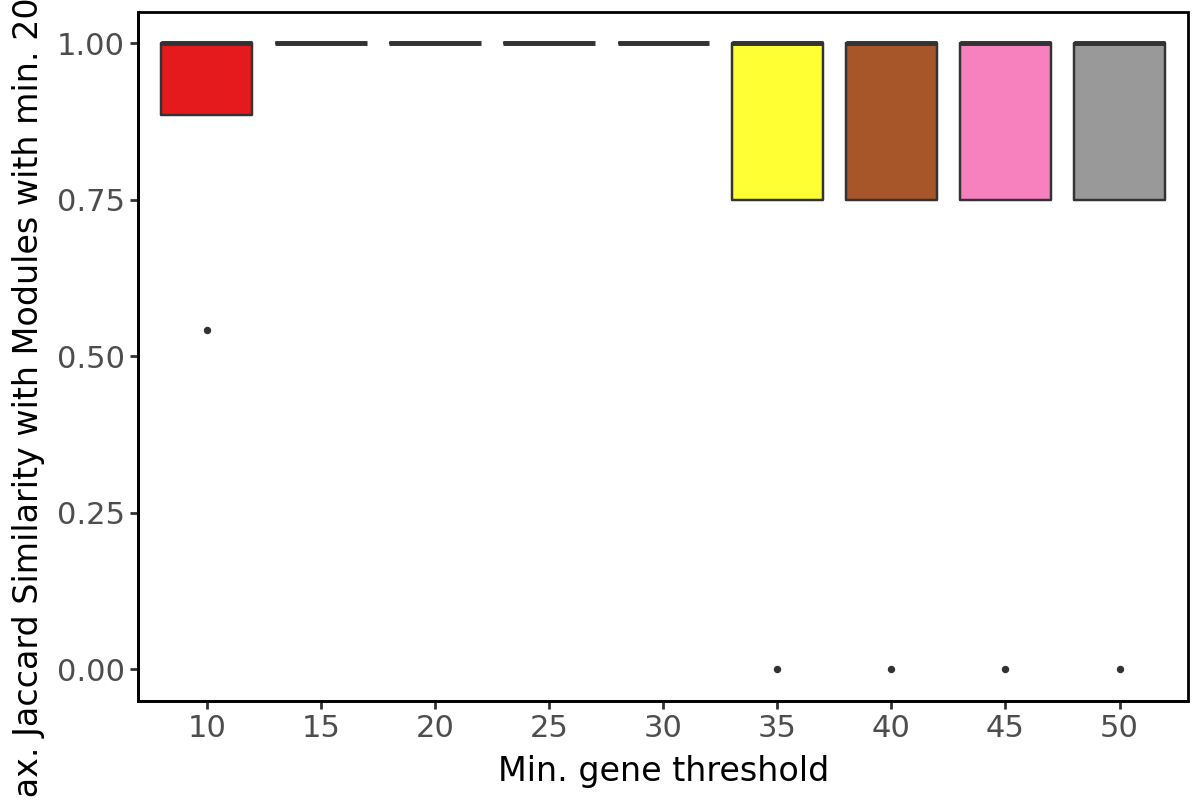

In [17]:
fig = (
ggplot(data=jaccard_values_df, mapping=aes(x="ngenes", y="Value", fill="ngenes")) 
+ geom_boxplot(width=0.8, outlier_shape="o", outlier_size=0.5)
# + geom_jitter(width = 0.2, size=0.5, alpha=0.6)
+ scale_fill_manual(values=["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33", "#A65628", "#F781BF", "#999999"])
+ xlab('Min. gene threshold')
+ ylab(f'Max. Jaccard Similarity with Modules with min. {ref_value} genes')
+ theme_classic() 
# + ylim(0,1)
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
# fig.save(os.path.join(PLOTS_PATH, 'pairwise_cor_jaccard_min_gene_box_plot_no_points.svg'), format='svg')
fig

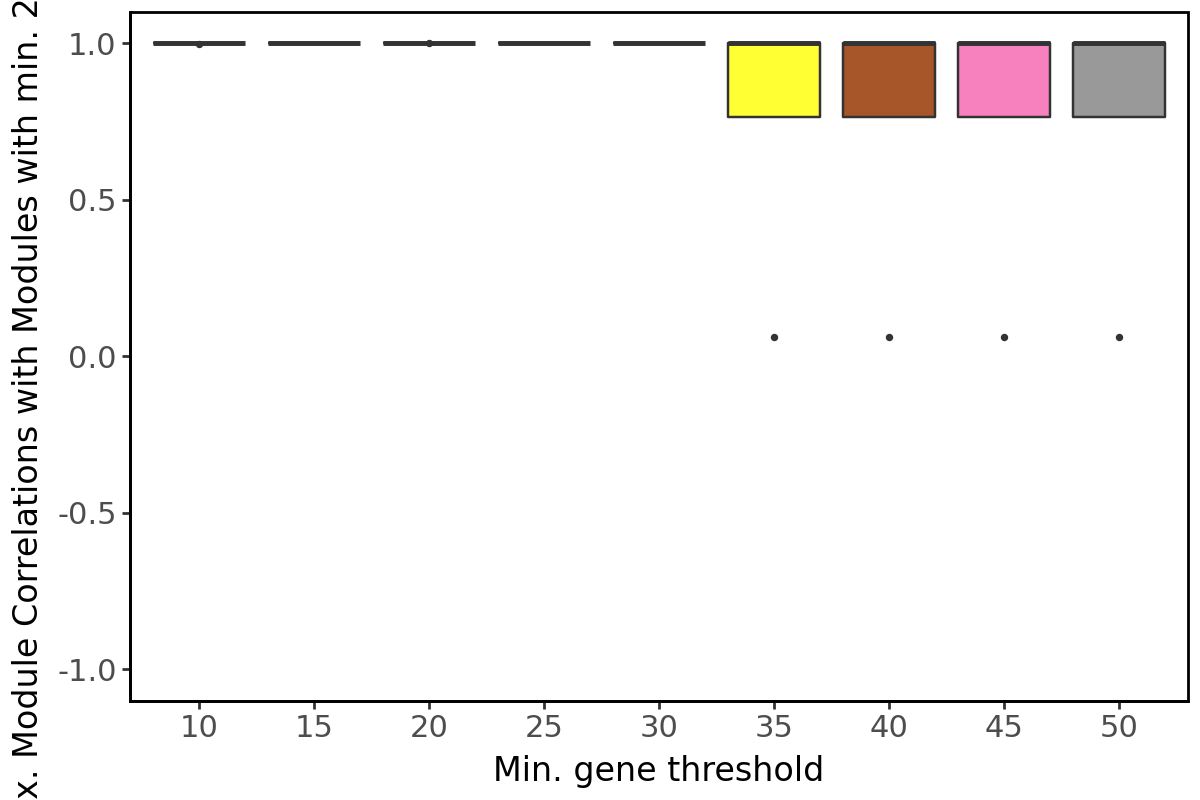

In [19]:
fig = (
ggplot(data=correlation_values_df, mapping=aes(x="ngenes", y="Value", fill="ngenes")) 
+ geom_boxplot(width=0.8, outlier_shape="o", outlier_size=0.5)
# + geom_jitter(width = 0.2, size=0.5, alpha=0.6)
+ scale_fill_manual(values=["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33", "#A65628", "#F781BF", "#999999"])
+ xlab('Min. gene threshold')
+ ylab(f'Max. Module Correlations with Modules with min. {ref_value} genes')
+ theme_classic() 
+ ylim(-1,1)
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 4))
)
# fig.save(os.path.join(PLOTS_PATH, 'pairwise_cor_max_cor_min_gene_box_plot_no_points.svg'), format='svg')
fig

In [20]:
y_ticks = range(0, n_modules_df['n_modules'].max() + 2, 2)

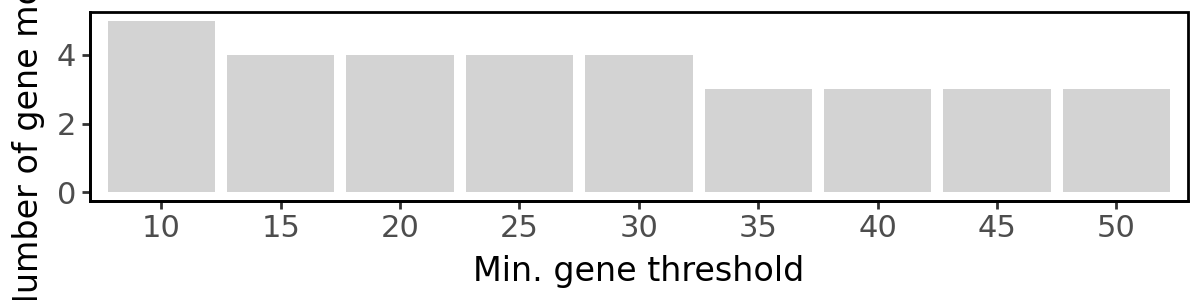

In [22]:
fig = (
ggplot(data=n_modules_df, mapping=aes(x="ngenes", y="n_modules")) 
+ geom_bar(stat='identity', fill='lightgrey') 
+ xlab('Min. gene threshold')
+ ylab('Number of gene modules')
+ scale_y_continuous(breaks=y_ticks)
+ theme_classic() 
+ theme(plot_title = element_text(hjust = 0.5,
                                margin={"t": 0, "b": 5, "l": 0, "r": 0},
                                size = 14,
                                face='bold'),
        legend_position = "none",
        axis_title_x = element_text(size = 12),
        axis_title_y = element_text(size = 12),
        axis_text_x = element_text(margin={"t": 0, "b": 0, "l": 10, "r": 0}, size = 11),
        axis_text_y = element_text(margin={"t": 0, "b": 0, "l": 0, "r": 10}, size = 11),
        panel_border = element_rect(color='black'),
        panel_background = element_rect(colour = "black",
                                        linewidth = 1),
        figure_size=(6, 1.5))
)
# fig.save(os.path.join(PLOTS_PATH, 'n_modules_min_gene_bar_plot.svg'), format='svg')
fig

## Comparison between the Hotspot pairwise correlation and Pearson correlation

In [2]:
adata = harreman.read_h5ad(os.path.join(ADATA_PATH, 'Slide_seq_lung_metab_Hotspot_adata.h5ad'))

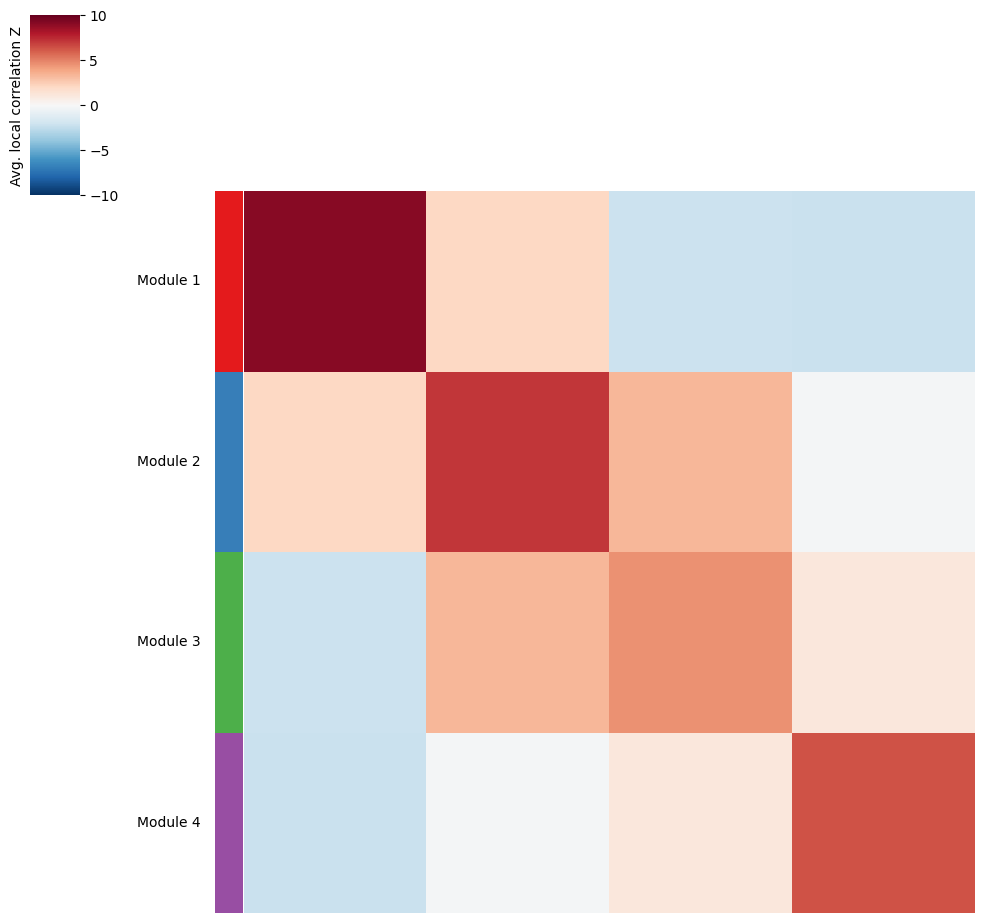

In [3]:
harreman.pl.average_local_correlation_plot(adata, col_cluster=False, row_cluster=False, mod_cmap='Set1', show=False)
# plt.savefig(os.path.join(PLOTS_PATH, 'avg_local_correlation_plot.svg'))

In [4]:
N_BIN_TARGET = 30
def bernoulli_model(gene_detects, umi_counts):

    # We modify the 0 UMI counts to 1e-10 to remove the NaN values from the qcut output.
    umi_counts[umi_counts == 0] = 1e-10
    
    umi_count_bins, bins = pd.qcut(
        np.log10(umi_counts), N_BIN_TARGET, labels=False, retbins=True,
        duplicates='drop'
    )
    bin_centers = np.array(
        [bins[i] / 2 + bins[i + 1] / 2 for i in range(len(bins) - 1)]
    )

    N_BIN = len(bin_centers)

    bin_detects = bin_gene_detection(gene_detects, umi_count_bins, N_BIN)

    lbin_detects = logit(bin_detects)

    X = np.ones((N_BIN, 2))
    X[:, 1] = bin_centers
    Y = lbin_detects

    b = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
    detect_p = ilogit(b[0] + b[1] * np.log10(umi_counts))

    mu = detect_p
    var = detect_p * (1 - detect_p)
    x2 = detect_p

    return mu, var, x2

@njit
def bin_gene_detection(gene_detects, umi_count_bins, N_BIN):
    bin_detects = np.zeros(N_BIN)
    bin_totals = np.zeros(N_BIN)

    for i in range(len(gene_detects)):
        x = gene_detects[i]
        bin_i = umi_count_bins[i]
        bin_detects[bin_i] += x
        bin_totals[bin_i] += 1

    # Need to account for 0% detects
    #    Add 1 to numerator and denominator
    # Need to account for 100% detects
    #    Add 1 to denominator

    return (bin_detects+1) / (bin_totals+2)

@njit
def logit(p):
    return np.log(p / (1 - p))

@njit
def ilogit(q):
    return np.exp(q) / (1 + np.exp(q))

In [5]:
def create_centered_counts_row(vals_x, model, num_umi):
    vals_x = (vals_x > 0).astype('double')
    mu_x, var_x, x2_x = bernoulli_model(
        vals_x, num_umi)
    
    var_x[var_x == 0] = 1
    out_x = (vals_x-mu_x)/(var_x**0.5)
    out_x[out_x == 0] = 0

    return out_x

In [6]:
def create_centered_counts(counts, model, num_umi):
    """
    Creates a matrix of centered/standardized counts given
    the selected statistical model
    """
    out = np.zeros_like(counts, dtype='double')

    for i in range(out.shape[0]):

        vals_x = counts[i]

        out_x = create_centered_counts_row(
            vals_x, model, num_umi)

        out[i] = out_x

    return out

In [7]:
from scipy.sparse import issparse

In [10]:
gene_autocorrelation_results = adata.uns['gene_autocorrelation_results']
genes = gene_autocorrelation_results.loc[gene_autocorrelation_results.Z_FDR < 0.01].sort_values('Z', ascending=False).index

In [11]:
counts = adata[:, genes].layers['counts']
counts = counts.transpose()

is_sparse = issparse(counts)

if not is_sparse:
    counts = np.asarray(counts)

counts = counts.A if is_sparse else counts

In [12]:
num_umi = adata.uns['umi_counts']

In [13]:
sample_key = adata.uns['sample_key']
for sample in adata.obs[sample_key].unique().tolist():
    subset = np.where(adata.obs[sample_key] == sample)[0]
    counts[:,subset] = create_centered_counts(counts[:,subset], 'bernoulli', num_umi[subset])

In [14]:
pearson_cor_matrix = pd.DataFrame(np.corrcoef(counts), index=genes, columns=genes)

In [15]:
from scipy.cluster.hierarchy import leaves_list

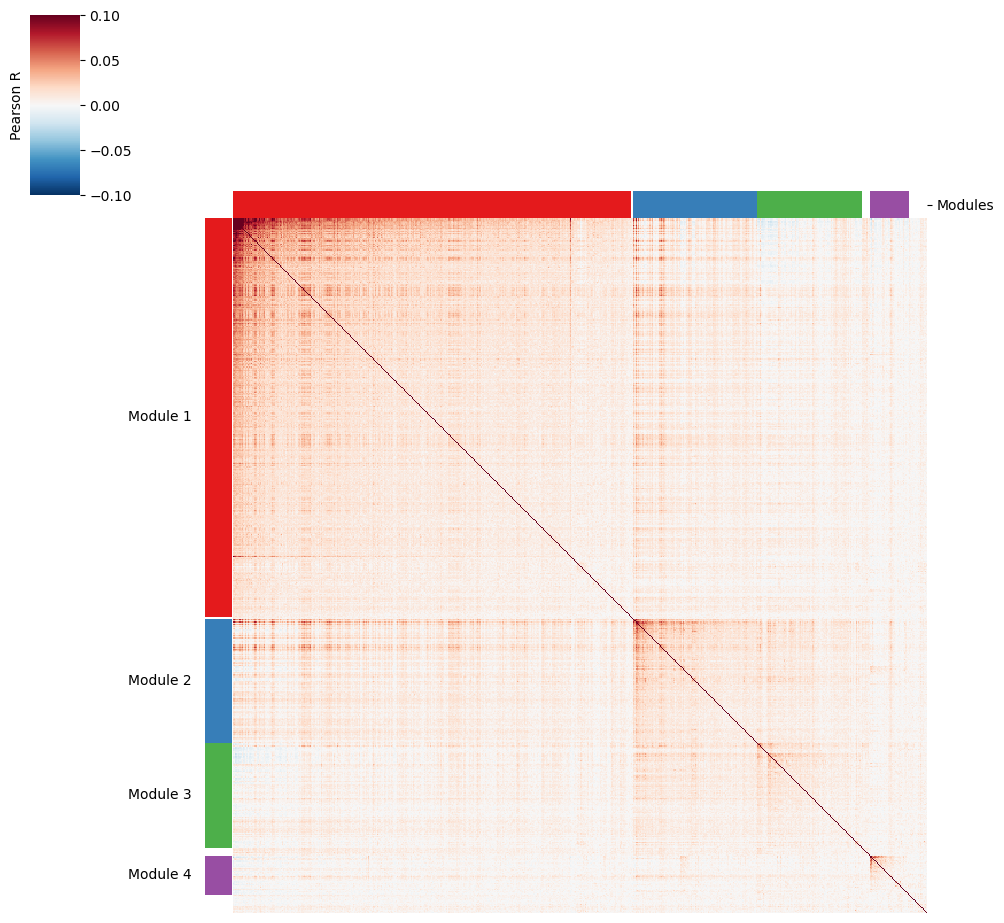

In [17]:
mod_cmap='Set1'
vmin=-0.1
vmax=0.1
z_cmap='RdBu_r'
yticklabels=False
use_super_modules=False
row_colors=True,
col_colors=None,

local_correlation_z = pearson_cor_matrix
modules = adata.uns["super_modules"] if use_super_modules else adata.uns["modules"]
linkage = adata.uns["linkage"]

row_colors = None
colors = list(plt.get_cmap(mod_cmap).colors)
module_colors = {i: colors[(i-1) % len(colors)] for i in modules.unique()}
module_colors[-1] = '#ffffff'

modules = modules[local_correlation_z.index]

row_colors1 = pd.Series(
    [module_colors[i] for i in modules],
    index=local_correlation_z.index,
)

row_colors = pd.DataFrame({
    "Modules": row_colors1,
})

col_colors = row_colors if col_colors is True else None

cm = sns.clustermap(
    local_correlation_z,
    row_linkage=linkage,
    col_linkage=linkage,
    vmin=vmin,
    vmax=vmax,
    cmap=z_cmap,
    xticklabels=False,
    yticklabels=yticklabels,
    row_colors=row_colors,
    col_colors=row_colors,
    rasterized=True,
)

fig = plt.gcf()
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()
cm.ax_col_dendrogram.remove()
# Add 'module X' annotations
ii = leaves_list(linkage)

mod_reordered = modules.iloc[ii]

adata.uns['mod_reordered'] = [mod for mod in mod_reordered.unique() if mod != -1]

mod_map = {}
y = np.arange(modules.size)

for x in mod_reordered.unique():
    if x == -1:
        continue

    mod_map[x] = y[mod_reordered == x].mean()

plt.sca(cm.ax_row_colors)
for mod, mod_y in mod_map.items():
    plt.text(-.5, y=mod_y, s="Module {}".format(mod),
                horizontalalignment='right',
                verticalalignment='center')
plt.xticks([])

# Find the colorbar 'child' and modify
min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Pearson R')
min_aa.yaxis.set_label_position("left")

# plt.savefig(os.path.join(PLOTS_PATH, 'pearson_correlation_plot.svg'))

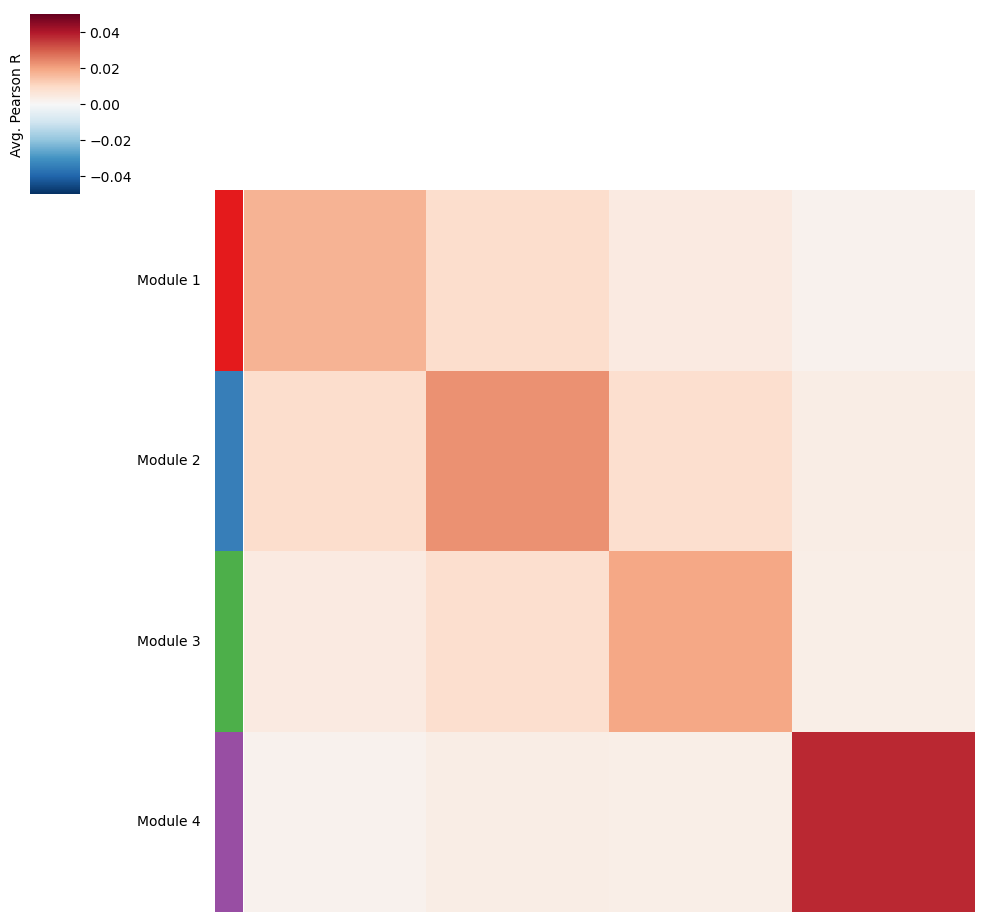

In [18]:
mod_cmap='Set1'
vmin=-0.05
vmax=0.05
cor_cmap='RdBu_r'
yticklabels=False
row_cluster=False
col_cluster=False
show=False

local_correlation_z = pearson_cor_matrix
modules = adata.uns["modules"]

avg_local_correlation_z = local_correlation_z.copy()
avg_local_correlation_z['module_row'] = modules
avg_local_correlation_z = avg_local_correlation_z.set_index('module_row', append=True)
avg_local_correlation_z.columns = pd.MultiIndex.from_arrays([modules[avg_local_correlation_z.columns].values, avg_local_correlation_z.columns])

avg_local_correlation_z = avg_local_correlation_z.groupby(level=1).mean().groupby(level=0, axis=1).mean()
avg_local_correlation_z = avg_local_correlation_z.loc[avg_local_correlation_z.index != -1, avg_local_correlation_z.columns != -1]
mod_reordered = adata.uns['mod_reordered']
avg_local_correlation_z = avg_local_correlation_z.loc[mod_reordered, mod_reordered]

row_colors = None
colors = list(plt.get_cmap(mod_cmap).colors)
module_colors = {i: colors[(i-1) % len(colors)] for i in modules.unique()}
module_colors[-1] = '#ffffff'

row_colors = pd.DataFrame({
    "Modules": module_colors,
})

cm = sns.clustermap(
    avg_local_correlation_z,
    vmin=vmin,
    vmax=vmax,
    cmap=cor_cmap,
    xticklabels=False,
    yticklabels=yticklabels,
    row_colors=row_colors,
    rasterized=True,
    row_cluster=row_cluster,
    col_cluster=col_cluster,
)

fig = plt.gcf()
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

cm.ax_row_dendrogram.remove()

if row_cluster:
    reordered_indices = cm.dendrogram_row.reordered_ind
    mod_reordered = [avg_local_correlation_z.index[i] for i in reordered_indices]

mod_map = {}
y = np.arange(len(mod_reordered))

for x in mod_reordered:
    if x == -1:
        continue

    mod_map[x] = y[mod_reordered == x].mean() + 0.5

plt.sca(cm.ax_row_colors)
for mod, mod_y in mod_map.items():
    plt.text(-.5, y=mod_y, s="Module {}".format(mod),
                horizontalalignment='right',
                verticalalignment='center')
plt.xticks([])

# Find the colorbar 'child' and modify
min_delta = 1e99
min_aa = None
for aa in fig.get_children():
    try:
        bbox = aa.get_position()
        delta = (0-bbox.xmin)**2 + (1-bbox.ymax)**2
        if delta < min_delta:
            delta = min_delta
            min_aa = aa
    except AttributeError:
        pass

min_aa.set_ylabel('Avg. Pearson R')
min_aa.yaxis.set_label_position("left")

if show:
    plt.show()

# plt.savefig(os.path.join(PLOTS_PATH, 'avg_pearson_correlation_plot.svg'))

In [19]:
np.fill_diagonal(pearson_cor_matrix.values, 0)

Text(0, 0.5, 'Pearson R')

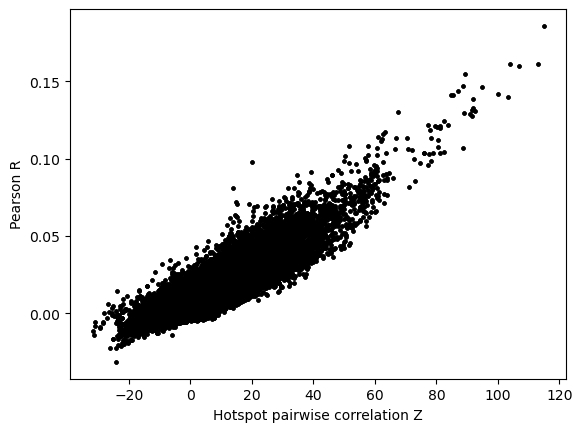

In [20]:
# global consistency
x = adata.uns['lc_zs'].values.flatten()
y = pearson_cor_matrix.values.flatten()
plt.scatter(x, y, s=5, color='black')
# plt.ylim(-0.1, 0.1)
plt.xlabel('Hotspot pairwise correlation Z')
plt.ylabel('Pearson R')
# plt.savefig(os.path.join(PLOTS_PATH, 'pearson_lc_scatter_plot.png'))